## Partitions in Cassandra

In [1]:
CREATE KEYSPACE demo_ks
   WITH replication = {
     'class':'SimpleStrategy',
     'replication_factor': 1
   };

AlreadyExists
--------
Keyspace 'demo_ks' already exists

In [2]:
USE demo_ks;

In [3]:
CREATE TABLE books_by_author (
   author text,
   title  text,
   isbn   text,
   published_year  int,
   publisher  text,
   category   text,
   PRIMARY KEY((author), title, isbn));

                                                         AlreadyExists
--------
Table 'demo_ks.books_by_author' already exists

In [4]:
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-8175993426','Anna Karenina','LeoTolstoy',2015,'Fingerprint Publishing','History & Criticism');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-1408855669', 'Harry Porter and the Chamber of Secrets', 'J.K.Rowling', 2014, 'Bloomsbury', 'Fantasy');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-1408855652', 'Harry Porter and the Philosoper''s Stone', 'J.K.Rowling', 2014, 'Bloomsbury','Fantasy');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-0007488308', 'Lord of the Rings: The Fellowship of the Ring', 'J.R.R.Tolkien', 2012, 'Harpercollins', 'Classic Fiction');
insert into books_by_author (isbn, title, author, published_year, publisher, category)
values ('978-1408855676', 'Harry Porter and the Prisoner of Azkaban', 'J.K.Rowling', 2014, 'Bloomsbury','Fantasy');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-0007488346', 'Lord of the Rings: The Return of the King', 'J.R.R.Tolkien', 2012, 'Harpercollins', 'Classic Fiction');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-0007488322', 'Lord of the Rings: The Two Towers', 'J.R.R.Tolkien', 2013, 'Harpercollins', 'Classic Fiction');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-1977066053', 'The Adventures of Tom Sawyer', 'MarkTwain', 2012, 'Amazon', 'Drama & Plays');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-1544712048', 'The Mysterious Stranger', 'MarkTwain', 2012, 'Amazon', 'Drama & Plays');
insert into books_by_author(isbn, title, author, published_year, publisher, category)
values ('978-8175992832', 'War and Peace', 'LeoTolstoy', 2014, 'Fingerprint Publishing', 'Classic Fiction');

In [5]:
// The token for rows are same, when the author is same.
// This token is used by cassandra to distribute partition data across nodes.

select author, token(author), title from books_by_author

                                                                                                                               
 author        | system.token(author) | title
---------------+----------------------+-----------------------------------------------
 J.R.R.Tolkien |    33977059392662464 | Lord of the Rings: The Fellowship of the Ring
 J.R.R.Tolkien |    33977059392662464 |     Lord of the Rings: The Return of the King
 J.R.R.Tolkien |    33977059392662464 |             Lord of the Rings: The Two Towers
    LeoTolstoy |  1121202131577552268 |                                 Anna Karenina
    LeoTolstoy |  1121202131577552268 |                                 War and Peace
     MarkTwain |  5440223371079860612 |                  The Adventures of Tom Sawyer
     MarkTwain |  5440223371079860612 |                       The Mysterious Stranger
   J.K.Rowling |  8929012386469871705 |       Harry Porter and the Chamber of Secrets
   J.K.Rowling |  8929012386469871705 |       Harry

In [6]:
// Now let us see which node got which partition data

!nodetool getendpoints demo_ks books_by_author "J.K.Rowling"
!nodetool getendpoints demo_ks books_by_author "J.R.R.Tolkien"
!nodetool getendpoints demo_ks books_by_author "MarkTwain"
!nodetool getendpoints demo_ks books_by_author "LeoTolstoy"

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Defining primary keys in CQL

In [7]:
// Definition 1 (partition key: log_hour, clustering columns: none)
// Here, all rows that share a log_hour go into the same partition.
CREATE TABLE server_logs(
   log_hour TIMESTAMP PRIMARY KEY,
   log_level text,
   message text,
   server text
   )

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [8]:
// Definition 2 (partition key: log_hour, clustering columns: log_level)
CREATE TABLE server_logs(
   log_hour TIMESTAMP,
   log_level text,
   message text,
   server text,
   PRIMARY KEY (log_hour, log_level)
   )

//This definition uses the same partition key as Definition 1, but here all rows in each partition are arranged in ascending order by log_level.

In [9]:
//Definition 3 (partition key: log_hour, server, clustering columns: none)

CREATE TABLE server_logs(
   log_hour TIMESTAMP,
   log_level text,
   message text,
   server text,
   PRIMARY KEY ((log_hour, server))
   )

//In this definition, all rows share a log_hour for each distinct server as a single partition.

In [10]:
//Definition 4 (partition key: log_hour, server, clustering columns: log_level)

CREATE TABLE server_logs(
   log_hour TIMESTAMP,
   log_level text,
   message text,
   server text,
   PRIMARY KEY ((log_hour, server),log_level)
   )WITH CLUSTERING ORDER BY (column3 DESC);


//This definition uses the same partition as Definition 3 but arranges the rows within a partition in descending order by log_level.

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Composite Partition Key

- If we need to combine more than one column value to form a single partition key, we use a composite partition key.

In [11]:
// The important thing to note in the above definition is the inner parenthesis around app_name and env primary key definition.
// This inner parenthesis specifies that app_name and env are part of a partition key and are not clustering keys.

CREATE TABLE application_logs (
  id                    INT,
  app_name              VARCHAR,
  hostname              VARCHAR,
  log_datetime          TIMESTAMP,
  env                   VARCHAR,
  log_level             VARCHAR,
  log_message           TEXT,
  PRIMARY KEY ((app_name, env))
);

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [12]:
select * FROM application_logs where app_name = 'app1' and env = 'prod';

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

- Note that combination of both keys is unique
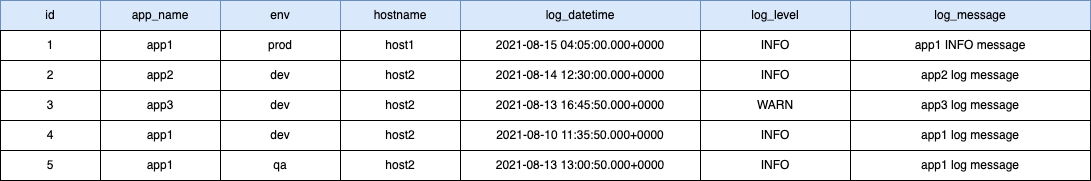

In [13]:
CREATE TABLE application_logs (
  id                    INT,
  app_name              VARCHAR,
  hostname              VARCHAR,
  log_datetime          TIMESTAMP,
  env                   VARCHAR,
  log_level             VARCHAR,
  log_message           TEXT,
  PRIMARY KEY ((app_name, env), hostname, log_datetime)
);

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [14]:
select * FROM application_logs where app_name = 'app1' and env = 'prod';

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

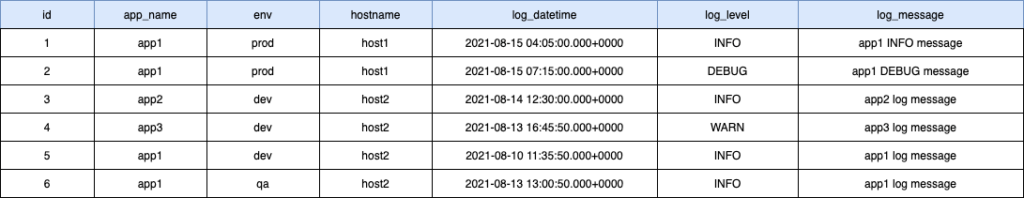